# Cognitive Services > Vision > Form Recognizer > Prebuilt APIs

## 1. Receipt API

## To run this notebook
1. Create From Recognizer resource
2. Create 'access_config.json' & provide endpoint & key for the resource (file should be located in the same dir as notebook, else you will need to update config file path)
3. Prepare testing file & update file path to point to this file

In [28]:
# load libraries
import os
import datetime
import json
import pprint

# SDK - available for C#, python, Java, JavaScript
from azure.core.exceptions import ResourceNotFoundError
from azure.ai.formrecognizer import FormRecognizerClient
from azure.core.credentials import AzureKeyCredential

# load API URL & Key from config file

# Config file wiht credentials structure:
# {
#     "form-reco": {
#         "key": "abc",
#         "endpoint": "resource_endpoint"
#     }
# }

config_file = os.path.normpath(os.path.join(os.getcwd(), 'access_config.json'))
with open(config_file, 'r') as j:
     config = json.loads(j.read())   

ENDPOINT = config['form.recognizer']['api'] # ex. https://xxxxxxxx.cognitiveservices.azure.com
KEY = config['form.recognizer']['key'] # ex. 234234werwer23424

In [29]:
def process_image(filepath):
    """ Send image for processing & receive result
    Params:
        filepath (str): path to image
    Returns:
        result (list): data extracted from reciept
    """
    result, success = None, False
    try:
        # AUTH
        form_recognizer_client = FormRecognizerClient(ENDPOINT, AzureKeyCredential(KEY))
        start_dt = datetime.datetime.now()

        with open(filepath, mode='rb') as file:
            poller = form_recognizer_client.begin_recognize_receipts(file.read())
            
        result = poller.result()

        # result returned by Service
        delta = datetime.datetime.now() - start_dt
        print('Time elapsed: %s' %delta)
        success = True

    except Exception as e:
        print('ERROR: image processing, %s' %e)
    
    return success, result

In [30]:
def process_result(result):
    """
    Processes the output of Receipt API
    Params:
        result (list): Receipt API processing result    
    Returns:
        bounding_boxes (list): list of bounding boxes for elements found
    """
    success = False
    bounding_boxes = []
    data_out = {}

    try:
        for receipt in result:
            print('-RAW DATA-------------------------------------')
            print(receipt)
            print('----------------------------------------------\n')

            for name, field in receipt.fields.items():

                if name == "Items":
                    data_out[name] = {}
                    print("Receipt Items:")
                    for idx, items in enumerate(field.value):
                        data_out[name][idx] = {}
                        print("\tItem #{}".format(idx + 1))
                        for item_name, item in items.value.items():
                            print("\t\t{}: {} has confidence {}".format(item_name, item.value, item.confidence))                                       
                            if getattr(item.value_data, 'bounding_box', False):
                                bounding_boxes.append(item.value_data.bounding_box)

                            data_out[name][idx][item_name] = item.value

                else:
                    if getattr(field.value_data, 'bounding_box', False):
                        # item doesn't have bounding box
                        bounding_boxes.append(field.value_data.bounding_box)
                    if field.value != None:
                        print("{}: {} has confidence {}".format(name, field.value, field.confidence))
                        data_out[name] = field.value
                    else: 
                        # when field value = None, but the text in FieldData is availble, example date time formats
                        print("{}: {} has confidence {} | value found in text attr".format(name, field.value_data.text, 
                                                                                           field.confidence))
                        data_out[name] = field.value_data.text
        print('\n')                
        pprint.pprint(data_out)
        success = True
    except Exception as e:
        print('ERROR: data post processing, %s' %e)
  
    return success, bounding_boxes

In [31]:
# Process image
filepath = os.path.normpath(os.path.join(os.getcwd(), 'BeaconReceipt_Demo.png'))

success, result = process_image(filepath)
if success:
    success_pr, bounding_boxes = process_result(result)

Time elapsed: 0:00:13.033575
-RAW DATA-------------------------------------
RecognizedForm(form_type=prebuilt:receipt, fields={'ReceiptType': FormField(value_type=string, label_data=None, value_data=None, name=ReceiptType, value='Itemized', confidence=0.943), 'MerchantName': FormField(value_type=string, label_data=None, value_data=FieldData(page_number=1, text=THE BEACON, bounding_box=[Point(x=243.9, y=195.8), Point(x=603.0, y=186.0), Point(x=604.2, y=229.2), Point(x=245.0, y=238.9)], field_elements=None), name=MerchantName, value='THE BEACON', confidence=0.767), 'TransactionDate': FormField(value_type=date, label_data=None, value_data=FieldData(page_number=1, text=14/11/2020, bounding_box=[Point(x=56.0, y=503.0), Point(x=250.0, y=506.0), Point(x=250.0, y=540.0), Point(x=56.0, y=540.0)], field_elements=None), name=TransactionDate, value=None, confidence=0.914), 'TransactionTime': FormField(value_type=time, label_data=None, value_data=FieldData(page_number=1, text=19:32, bounding_box=[P

In [32]:
# plot results
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

%matplotlib inline

def plot(filepath, bounding_boxes):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
    img = Image.open(filepath)
    ax.imshow(img)

    # add bounding boxes for the fields found in receipt
    for rec in bounding_boxes:
        ax.add_patch(mpatches.Polygon(rec, fill=False, color='magenta'))

    plt.axis('off')
    plt.show()
    

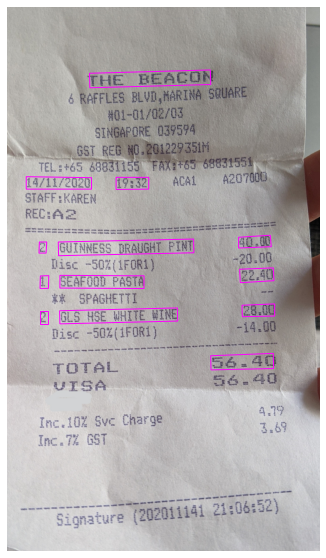

In [33]:
if success_pr:
    plot(filepath, bounding_boxes)